In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from os import listdir

import re

import sys
import os
# sys.path.append("/home/kalmar/Mathematics/Software/Dionysus/build-x64/bindings/python/")
# sys.path.append("/home/kalmar/Dropbox/devel/Dionysus-python3/build-i686/bindings/python/")
# import dionysus

%reload_ext autoreload
%autoreload 2

from TDA import Pair

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
prefix = 'sampled-2000'
pattern = re.compile('pair[0-9]{4,}$')
files = sorted([x for x in os.listdir(os.path.join(os.getcwd(),prefix)) if pattern.match(x)])
print(len(files))

75


In [ ]:
# p = Pair(prefix,files[0])

In [ ]:
# for each in files[3:]:
#     p=Pair(prefix,each)

In [4]:
class PairResults:
    try:
        all_pairs_metadata = np.loadtxt(os.path.join(os.getcwd(), 'pairs', 'pairmeta.txt'))
    except FileNotFoundError:
        print("No metadata found! All is set to 0")
        pairs_metadata = np.zeros((88, 6))
    
    def __init__(self, prefix, name, threshold=0, outlier_model='knn'):
        if name[-4:] == '.txt':
            name = name[:-4]
        self.name = name
        self.number = int(name[-4:])
        self.metadata = self.all_pairs_metadata[self.number-1] 
        
        if self.metadata[1] == 1:
            self.causality_true = 1
        else:
            self.causality_true = -1
        
        self.weight = self.metadata[5]
        
        self.directory = os.path.join(os.getcwd(),prefix,name)
        if outlier_model == 'knn':
            self.results = ResultsModel(np.loadtxt(os.path.join(self.directory,"scores_knn")),threshold)
        elif outlier_model == 'all':
            self.results = ResultsModel(np.loadtxt(os.path.join(self.directory,"scores_all")),threshold)
        else:
            print("PairResults: unknown model?!")

class ResultsModel:
    
    def __init__(self, results, threshold):
        self.x_causes_y_scores = results[0]
        self.y_causes_x_scores = results[1]
        #----------------------
        #  causality_inferred = 0 (undecided)
        #                   1 (X->Y)
        #                  -1 (Y->X)
        #---------------------
        self.causality_inferred = self.decide_causality()
        
    def decide_causality(self, threshold=0):
        tmp = self.compute_confidence()
        self.confidence = np.abs(tmp)        
        if np.abs(tmp) <= threshold:
            return 0
        else:
            return tmp/np.abs(tmp)
        
    def compute_confidence(self):
        integral = sum(self.x_causes_y_scores - self.y_causes_x_scores)/self.x_causes_y_scores.shape[0]
        return integral

75
0.6334640625
75
0.6334640625


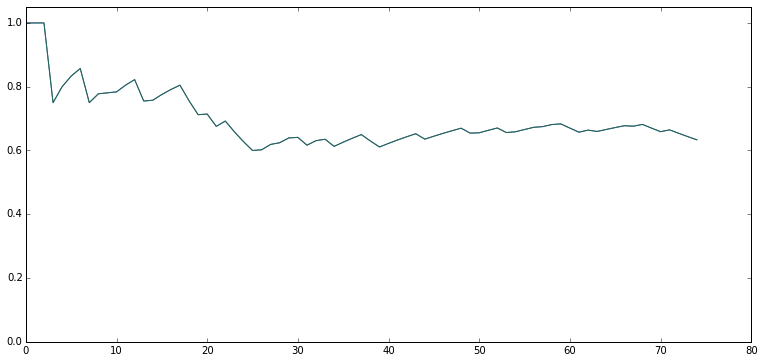

None

In [5]:
class AnalysisOfResults:
        
    def __init__(self, files, prefix='test', threshold=0, outlier_model='knn'):
        
        self.pairs = [PairResults(prefix, file, outlier_model) for file in files]
        self.pairs.sort(key=lambda x: x.results.confidence, reverse=True)
        self.pairs_decided = [x for x in self.pairs if x.results.causality_inferred != 0]
        print(len(self.pairs_decided))
        self.decisions_vector = [x.results.causality_inferred for x in self.pairs_decided]

        self.decisions_got_right = [x.results.causality_inferred == x.causality_true 
                                    for x in self.pairs_decided]
        self.weighted_decisions = [x.weight*(x.results.causality_inferred == x.causality_true)
                                       for x in self.pairs_decided]
        
        self.all_weights = [x.weight for x in self.pairs_decided]
#         self.weighted_efficiency = sum(self.weighted_decisions)/sum(self.all_weights)
        
        #auxilary helper functions
        
#         self.pair_confidences = [[result.number, result.confidence] 
#                           for result in self.results if result.right != -1]
#         self.correct_pair_confidences = [[result.number, result.confidence] 
#                                   for result in self.results if result.right == 1]
#         self.wrong_pair_confidences = [[result.number, result.confidence] 
#                                   for result in self.results if result.right == 0]
#         self.undecided_pair_confidences = [[result.number, result.confidence] 
#                                   for result in self.results if result.right == -1]

    def weighted_efficiency(self,i):
        return sum(self.weighted_decisions[:i])/sum(self.all_weights[:i])
        
    def plot(self, threshold=0):       
        max = len([x for x in self.pairs if 
                   x.results.confidence >= threshold and 
                   x.results.causality_inferred != 0])
        to_plot = [self.weighted_efficiency(i) for i in range(1,len(self.decisions_vector)+1)]
        plt.plot(to_plot, color = 'black', alpha = 0.2)
        plt.plot(to_plot[:max], alpha = 0.6)
        plt.ylim(0,1.05)
        print(to_plot[max-1])
        
from IPython.html.widgets import widget, interact, interactive, fixed, FloatSlider, Dropdown
        
@interact(threshold = (0,1,0.01))
def dummy(threshold):
    fig = plt.figure(figsize=(12,12))
    fig.set_size_inches(13,6) 
    Y = AnalysisOfResults(files, prefix, threshold, outlier_model='all')
    Y.plot(threshold)
    X = AnalysisOfResults(files, prefix, threshold, outlier_model='knn')
    X.plot(threshold)
    plt.show()

In [ ]:
results = np.loadtxt('./' + prefix + '/' + prefix + '_results')
pairs = [Pair(x) for x in results]
pairs.sort(key = lambda x: x.confidence, reverse = True)

In [ ]:
%timeit Pair(files[37]) #on battery

In [ ]:
%timeit Pair(files[37]) #on AC

In [ ]:
files[37]

In [ ]:
x = [p.right for p in pairs]
z = x.count(1) / (x.count(1) + x.count(0))
print(x)
print(z)

In [ ]:
Y = AnalysisOfResults(prefix, 0.0)
Y.results[0].x_noninj
Y.results[0].y_noninj
Y.results[0].true_causality
len(Y.results_raw)


In [ ]:
np.asarray(Y.wrong_pair_confidences, dtype = int)[:,0]

In [ ]:
np.loadtxt("asdfds")